---
# **Exercise: Ensemble Model Boosting**
---

**Study case: Bank Customer Churn prediction**

**Instructions:**

* Create a machine learning model that can predict which customers will leave the bank!
* The goal is to determine whether a customer will churn (stop using the bank's services).

**Dataset overview:**

* It consists of 10000 observations and 12 variables.
* Independent variables contain information about customers.
* Dependent variable refers to customer abandonment.

**Features:**

* Surname: Surname
* CreditScore: Credit score
* Geography: Country (Germany/ France/ Spain)
* Gender: Gender (Female/ Male)
* Age: Age
* Tenure: How many years of customer
* Balance: Balance
* NumOfProducts: The number of bank product used
* HasCrCard: Credit card status (0 = No, 1 = Yes)
* IsActiveMember: Active membership status (0 = No, 1 = Yes)
* EstimatedSalary: Estimated salary
* Exited: Churn or not? (0 = No, 1 = Yes)



* Conduct data exploration. What insights did you gain?
* Perform any data cleaning and preprocessing you deem necessary for this dataset.
* Determine the appropriate metrics for this dataset. Explain the reasons for choosing these metrics.
* Conduct modeling using decision trees, random forests, adaboost, gradientboost, or xgboost.
* Select the best model and perform hyperparameter tuning.
* Compare the results before and after tuning.

### **Initial Setup**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Data Splitting
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Preprocessing
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Resampler
from imblearn.over_sampling import RandomOverSampler, SMOTE # Oversampling
from imblearn.under_sampling import RandomUnderSampler # undersampling

# ML algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metrics
from sklearn.metrics import recall_score, classification_report, confusion_matrix

In [2]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('ggplot')

### **Business Understanding**

**Context**

The banking industry has grown rapidly, resulting in increasingly fierce competition between banks. One of the challenges banks now face is reducing the number of customers who stop using the company's services and switch to competitors.

A bank wants to understand which customers are likely to churn from the bank so that the number of customers who do so can be reduced. A data scientist is asked to create an accurate prediction model to determine whether customers will churn or not using the bank's services using machine learning.

Target:

0: Will not churn

1: Will churn

**Problem Statement:**

A high percentage of customer churn is an indicator of a bank's failure rate, so efforts are needed to reduce this percentage. Companies generally prefer to retain customers because it costs less to retain customers (customer retention costs) than to acquire new customers (customer acquisition costs). According to information from the internet, acquiring new customers can cost five times more than retaining existing ones. The average customer acquisition cost for the banking industry is around $200 per new customer ([source](https://www.skeps.com/blog/how-to-lower-bank-customer-acquisition-costs-skp#:~:text=Bank%20customer%20acquisition%20cost%20is,profit%20margins%20on%20each%20customer.)).

Banks can offer retention incentives such as attractive interest rates, attractive service packages, priority service, and other incentives to retain customers. However, retention incentive policies have not been fully implemented effectively. If these incentives are distributed equally to all customers, the costs are ineffective and reduce potential profits if the customer is loyal and does not want to stop using the service.

**Goals:**

Based on the problems above, the company wants to be able to predict whether a customer will stop using the service or not, so it can focus retention efforts on customers who are likely to churn.

Furthermore, the company wants to understand the factors that influence customer retention so they can develop more targeted programs to reduce churn.

**Analytic Approach:**

So, what we will do is analyze the data to find patterns that differentiate customers who will churn from those who will not.

Then, we will build a classification model that will help the company predict the probability of a customer churning.

**Metric Evaluation:**

Since our primary focus is customers who will churn, we have set the following targets:

Target:
- 0: Do not churn
- 1: Churn

Type 1 error: False Positive (customers who actually do not churn but are predicted to)
Consequence: Ineffective retention incentives

Type 2 error: False Negative (customers who actually churn but are predicted not to)
Consequence: Loss of customers

To provide a quantitative overview of the consequences, we will attempt to calculate the cost impact based on the following assumptions:
- Customer Lifetime Period for churned customers is approximately 5 years or 60 months
- Customer Acquisition Cost (CAC) = $200 per customer ([source](https://www.skeps.com/blog/how-to-lower-bank-customer-acquisition-costs-skp#:~:text=Bank%20customer%20acquisition%20cost%20is,profit%20margins%20on%20each%20customer.)) / 60 months = $3.33 per month per customer
- Customer Retention Cost (CRC) = 1/5 ([source](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/)) * CAC = 1/5 * $3.33 = $0.67 per month per customer
- Average Customer Monthly Charge = $7 per month per customer ([source](https://www.cnbc.com/select/how-to-avoid-bank-fees/))

Based on the above assumptions, we can quantify the consequences as follows:
- Ineffective retention incentives --> We waste $0.67 per month in CRC costs per customer
- Losing customers --> We lose revenue and also have to re-incur CAC costs, resulting in a total loss of $3.33 + $7 = $10.33 per month per customer

Based on these consequences, we will do our best to create a model that can reduce the company's customer churn, particularly the number of false negatives (customers who actually churn but are predicted not to), while also minimizing inappropriate incentives. Therefore, the primary metric we will use is the f2_score, as we consider recall to be twice as important as precision.

## **Data Understanding**

- The dataset depicts 10,000 customer data points.
- Each row represents information/characteristics of an individual, such as age, address, gender, and more, along with information on whether the customer has churned or not.

In [3]:
# Loading dataset
churn_csv = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/churn.csv'
data = pd.read_csv(churn_csv)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Data dimension
data.shape

(10000, 14)

**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- | 
|Surname |Text | Surname |
|CreditScore |Integer | CreditScore |
|Geography |Text | Country (Germany/ France/ Spain) |
|Gender |Text | Gender (Female/ Male) |
|Age |Integer | Age |
|Tenure |Integer | How many years of customer |
|Balance |Float | Balance |
|NumOfProducts |Integer | The number of bank product used |
|HasCrCard |Integer | Credit card status (0 = No, 1 = Yes) |
|IsActiveMember |Integer | Active membership status (0 = No, 1 = Yes) |
|EstimatedSalary |Float | Estimated salary |
|Exited |Integer | Churn or not? (0 = No, 1 = Yes) |

In [5]:
# Replacing values for EDA
data['HasCrCard'] = np.where(data['HasCrCard']==1, "Yes", "No")
data['IsActiveMember'] = np.where(data['IsActiveMember']==1, "Yes", "No")
data['Exited'] = np.where(data['Exited']==1, "Yes", "No")

**Initial Assesment**

In [6]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'missing values': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,missing values,negative,n_unique,sample_unique
0,RowNumber,int64,0.0,False,10000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,CustomerId,int64,0.0,False,10000,"[15634602, 15647311, 15619304, 15701354, 15737..."
2,Surname,object,0.0,False,2932,"[Hargrave, Hill, Onio, Boni, Mitchell, Chu, Ba..."
3,CreditScore,int64,0.0,False,460,"[619, 608, 502, 699, 850, 645, 822, 376, 501, ..."
4,Geography,object,0.0,False,3,"[France, Spain, Germany]"
5,Gender,object,0.0,False,2,"[Female, Male]"
6,Age,int64,0.0,False,70,"[42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 2..."
7,Tenure,int64,0.0,False,11,"[2, 1, 8, 7, 4, 6, 3, 10, 5, 9, 0]"
8,Balance,float64,0.0,False,6382,"[0.0, 83807.86, 159660.8, 125510.82, 113755.78..."
9,NumOfProducts,int64,0.0,False,4,"[1, 3, 2, 4]"


**Descriptive Statistics**

In [7]:
display(data.describe().T, data.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457
HasCrCard,10000,2,Yes,7055
IsActiveMember,10000,2,Yes,5151
Exited,10000,2,No,7963


### **Exploratory Data Analysis (EDA)**

#### `Numerical Features`

**Data distribution**

In [8]:
numerical = [var for var in data.columns if data[var].dtypes not in ['object']]

In [9]:
# Normality test
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(data[feature_name].dropna())
    
    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"
    
    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,RowNumber,8698.026597,0.000000e+00,Not Normally Distributed
1,CustomerId,8395.673079,0.000000e+00,Not Normally Distributed
2,CreditScore,132.828379,1.434445e-29,Not Normally Distributed
3,Age,1507.790888,0.000000e+00,Not Normally Distributed
4,Tenure,6481.918283,0.000000e+00,Not Normally Distributed
5,Balance,62973.389519,0.000000e+00,Not Normally Distributed
6,NumOfProducts,832.988863,1.314518e-181,Not Normally Distributed
7,EstimatedSalary,7397.149829,0.000000e+00,Not Normally Distributed


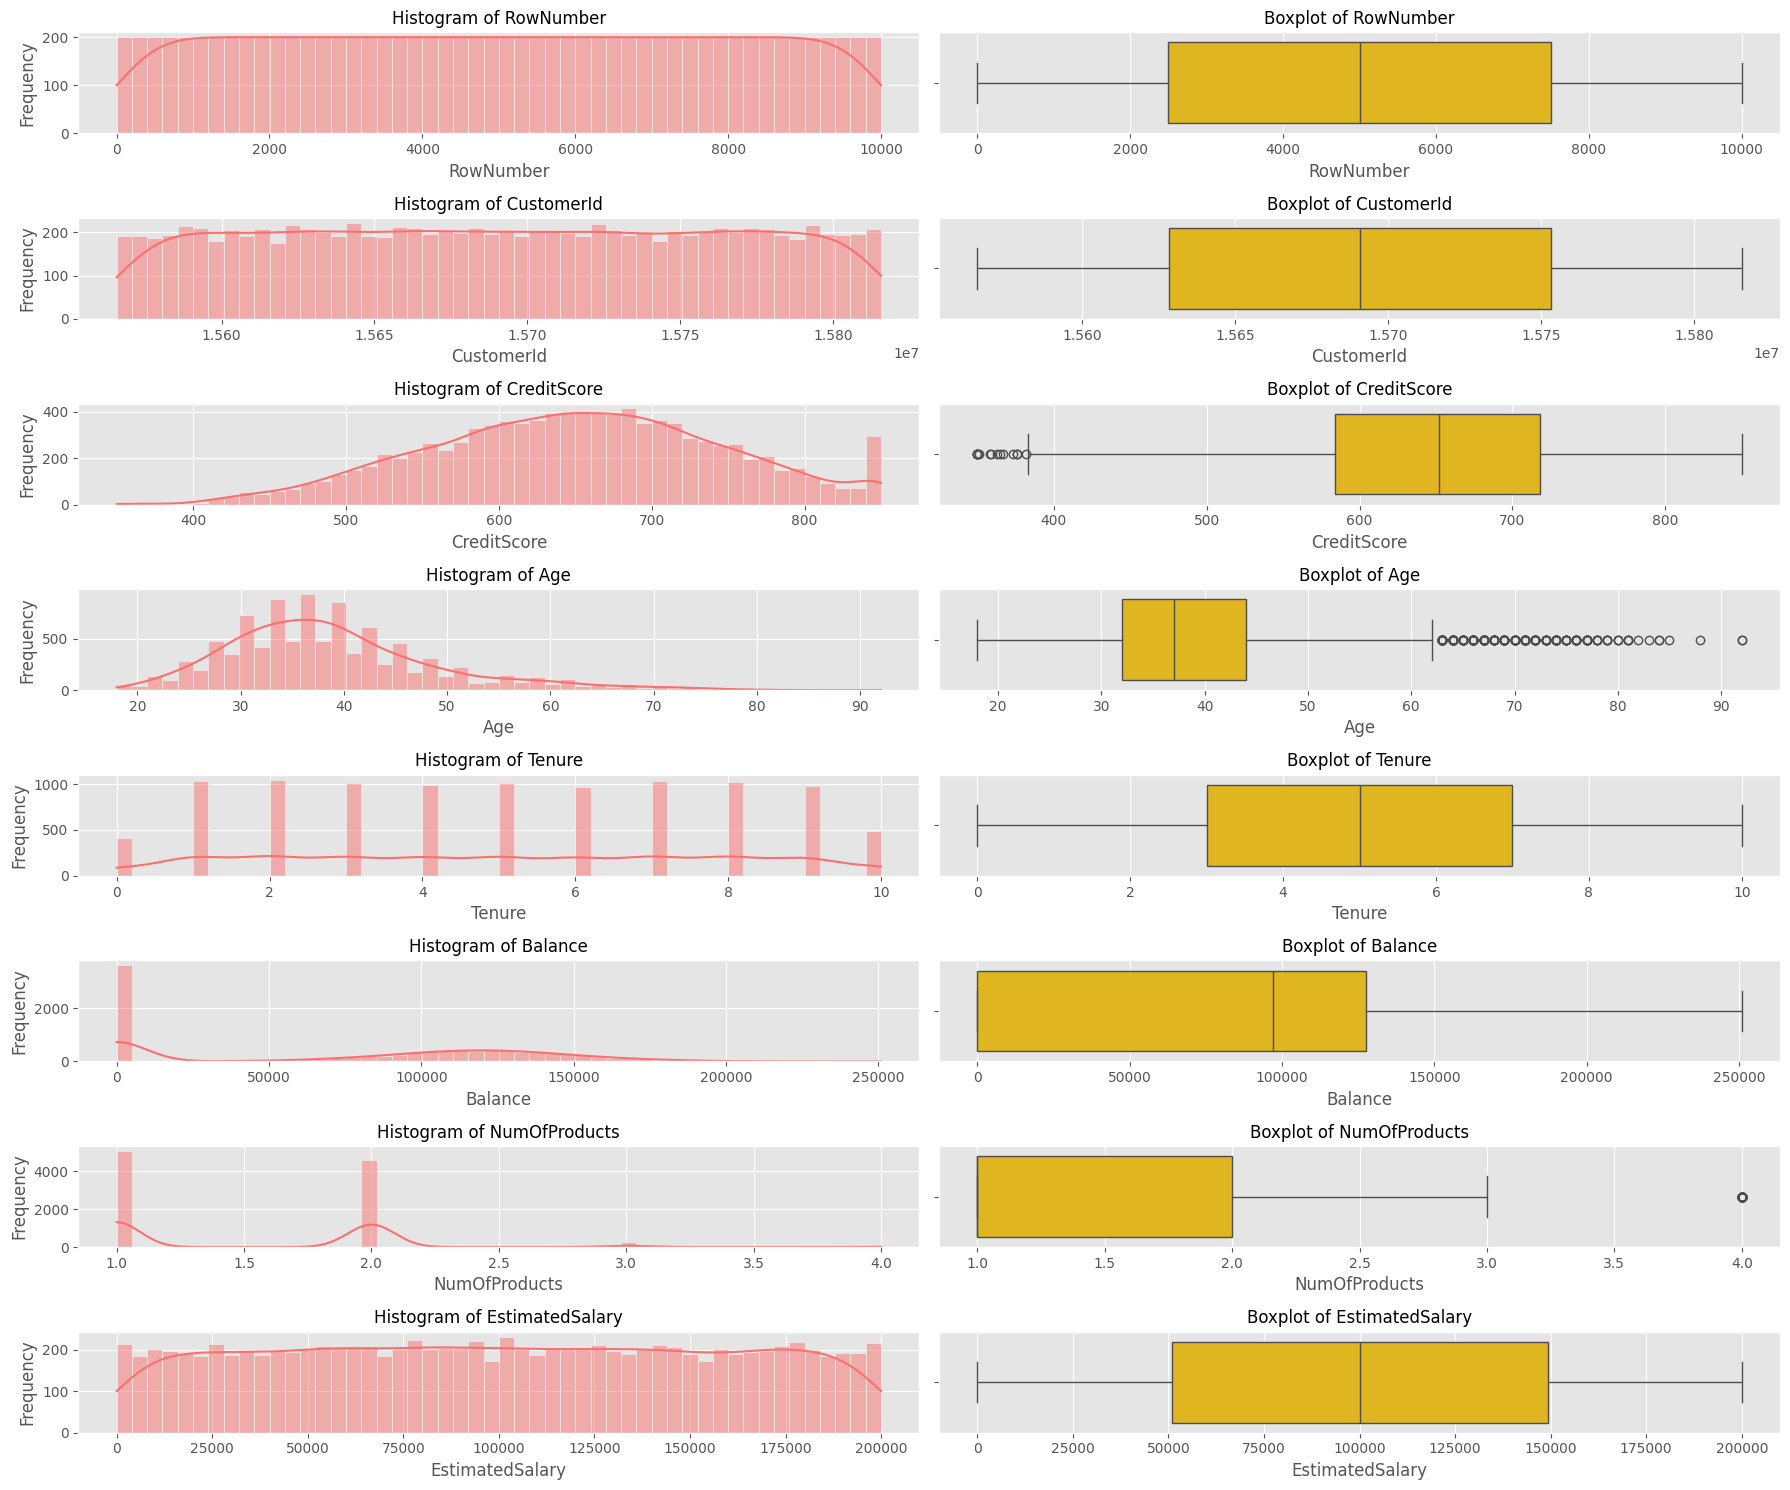

In [10]:
# Histogram and boxplot # data distribution
plt.figure(figsize=(18, 15))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Correlation**

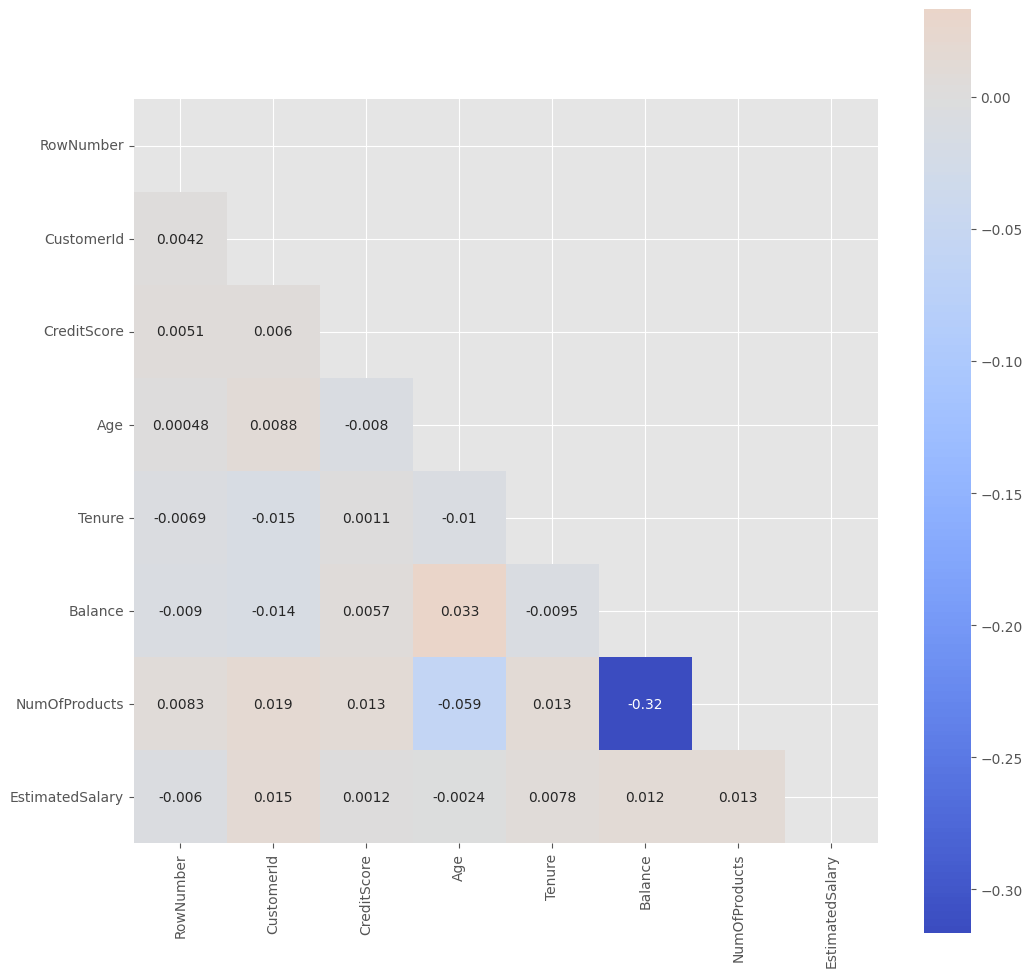

In [11]:
# Spearman Correlation
plt.figure(figsize=(12, 12))
numeric_data = data.select_dtypes(include=[np.number])
matrix = np.triu(numeric_data.corr(method='spearman'))

sns.heatmap(data=numeric_data.corr(method='spearman'), annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

**Feature vs Target**

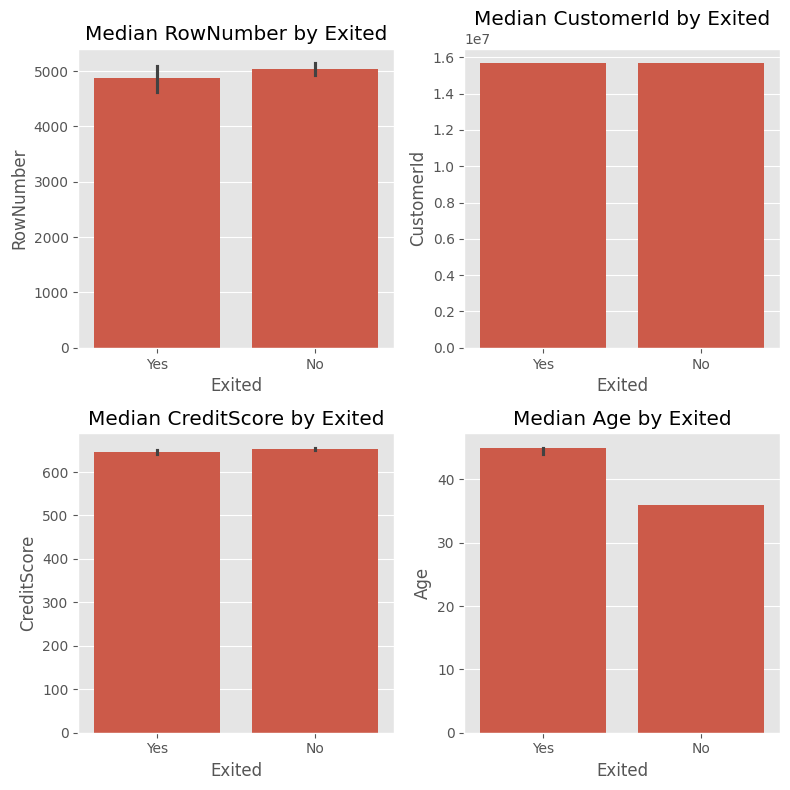

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for col, j in zip(numerical, axes.flatten()):
    ax = sns.barplot(data=data, y= col, x='Exited', estimator=np.median, ax= j)
    ax.set_title(f'Median {col} by Exited') 

plt.tight_layout()
plt.show()

#### `Categorical Features`

In [13]:
categorical = [var for var in data.drop(columns='Surname').columns if data[var].dtypes in ['object']]

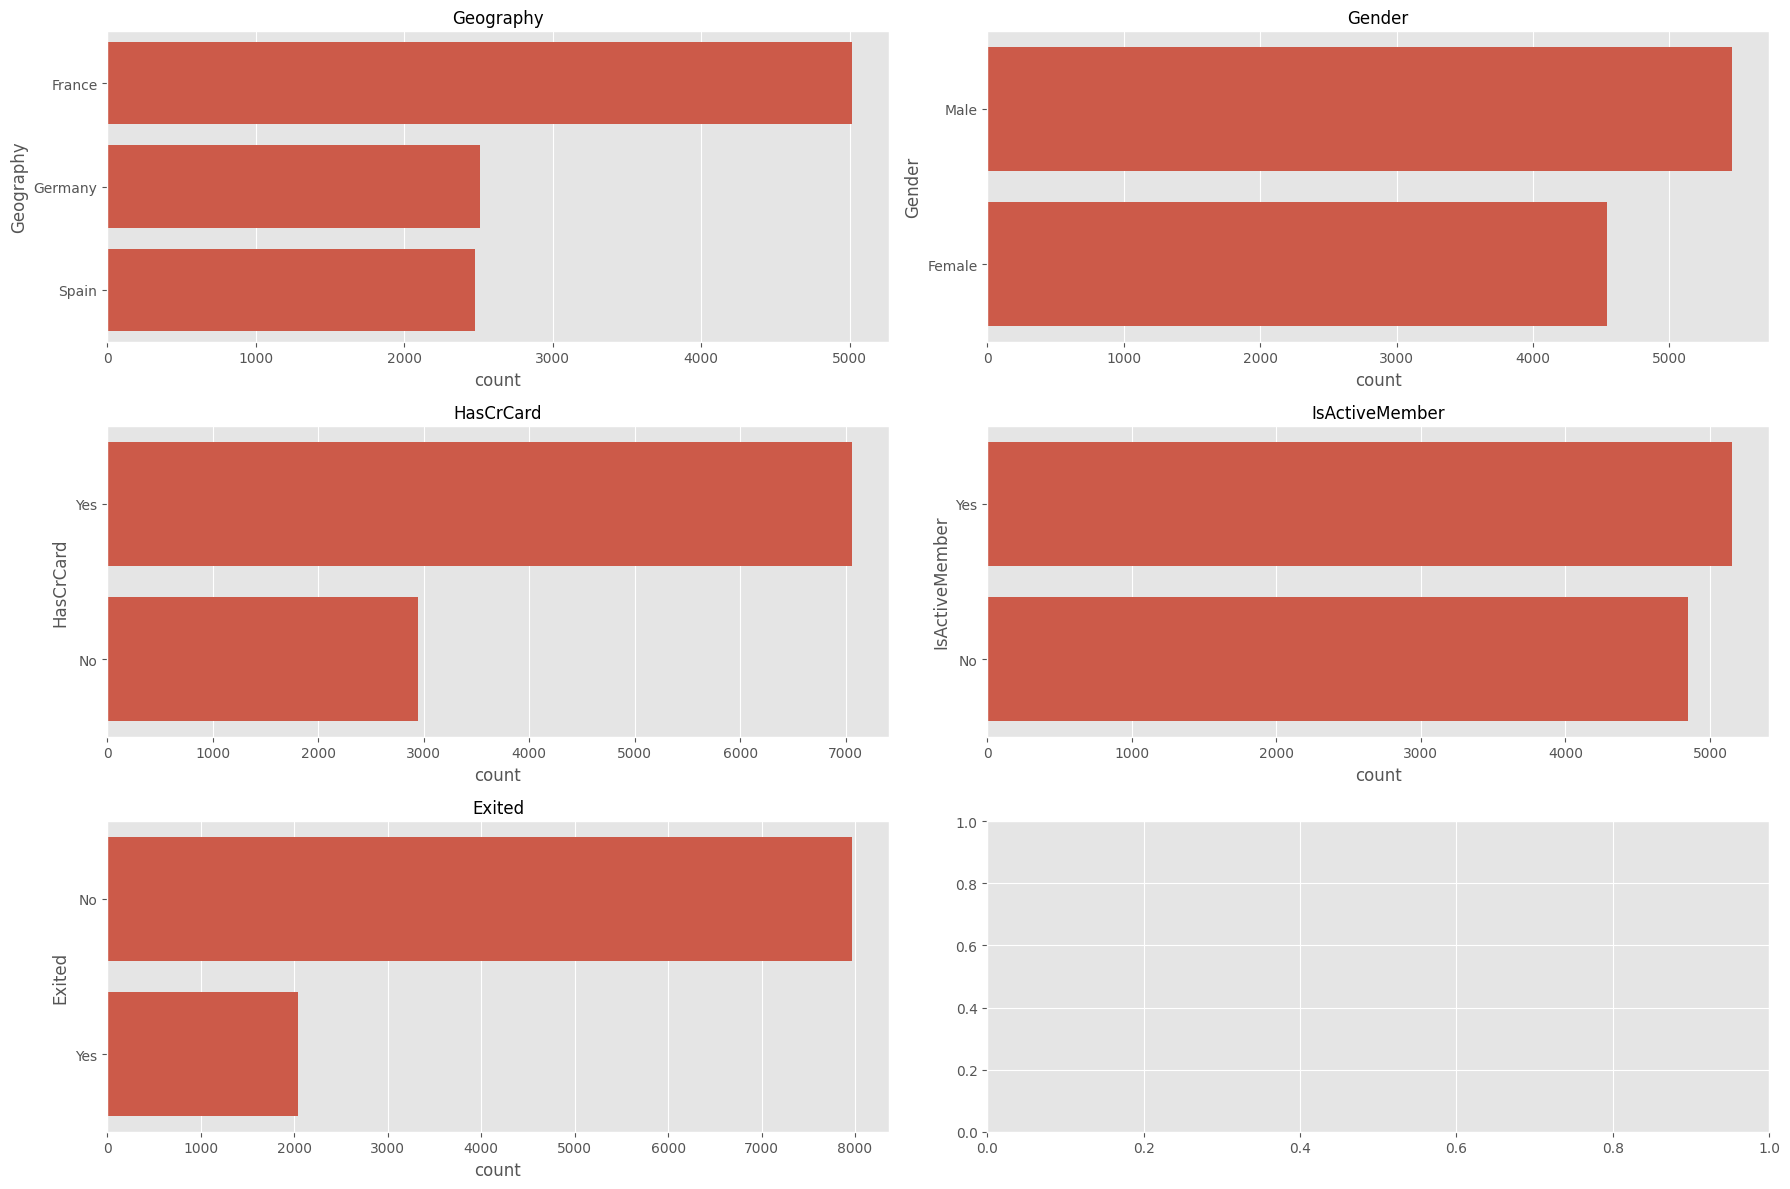

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12)) 
for i, j in zip(categorical, axes.flatten()):
    ax = sns.countplot(data=data, y= i, ax= j, order=data[i].value_counts().index)
    ax.set_title(f'{i}', size = 12) 

plt.tight_layout()
plt.show()

**Feature vs Target**

In [15]:
def create_plot(data, col, x_maks=1000):

    agg_table = data.groupby([col, 'Exited']).size().unstack().reset_index()
    agg_table['total'] = agg_table['Yes']+agg_table['No']
    agg_table['% Exited'] = (agg_table['Yes']/agg_table['total']*100).round(2)
    agg_table = agg_table.sort_values(by='% Exited', ascending=False)
    agg_table

    fig, axes = plt.subplots(1, 2, figsize=(16,5))

    ax1 = sns.barplot(data=agg_table, y=col, x='% Exited', ax=axes[0])
    label = ['{:.1f} %'.format(x) for x in ax1.containers[0].datavalues]
    ax1.bar_label(ax1.containers[0], labels=label, padding=3, label_type='center')
    ax1.set_title(f'Percentage of Exited passengers by {col}')

    ax2 = sns.countplot(data=data, y=col, hue='Exited', order=agg_table[col], ax=axes[1])
    ax2.set_title(f'Number of customer by {col} and churn')
    for container in ax2.containers:
        ax2.bar_label(container)
    ax2.set_xlim(0, x_maks)

    plt.tight_layout()
    plt.show()

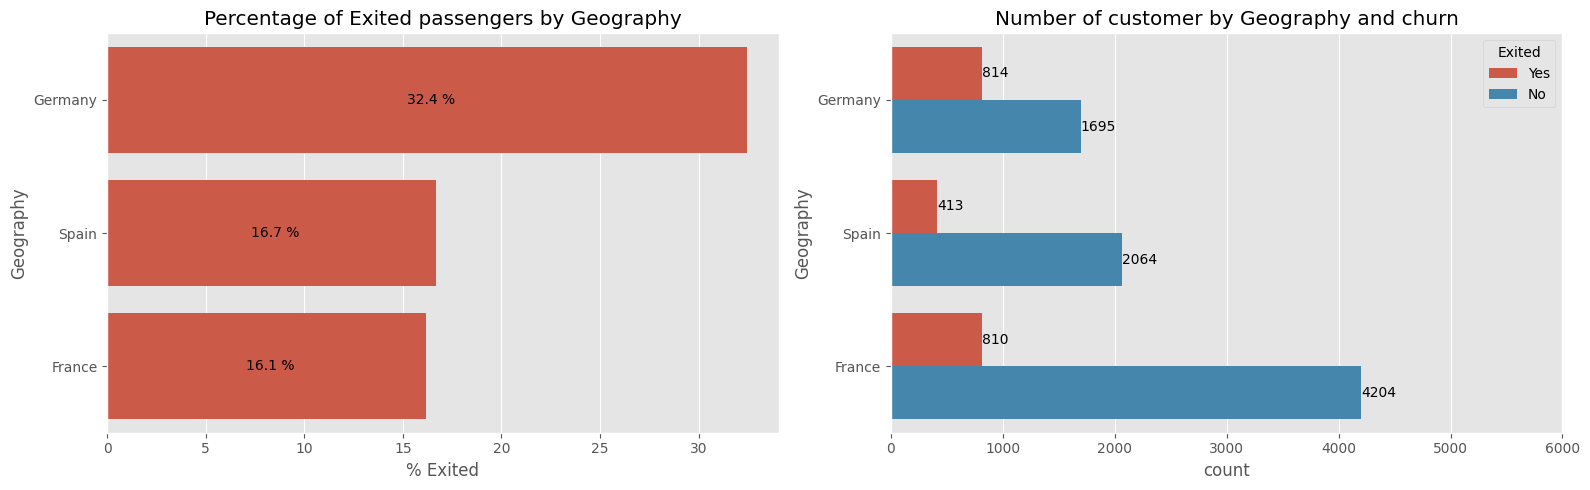

In [16]:
create_plot(data, 'Geography', x_maks=6000)

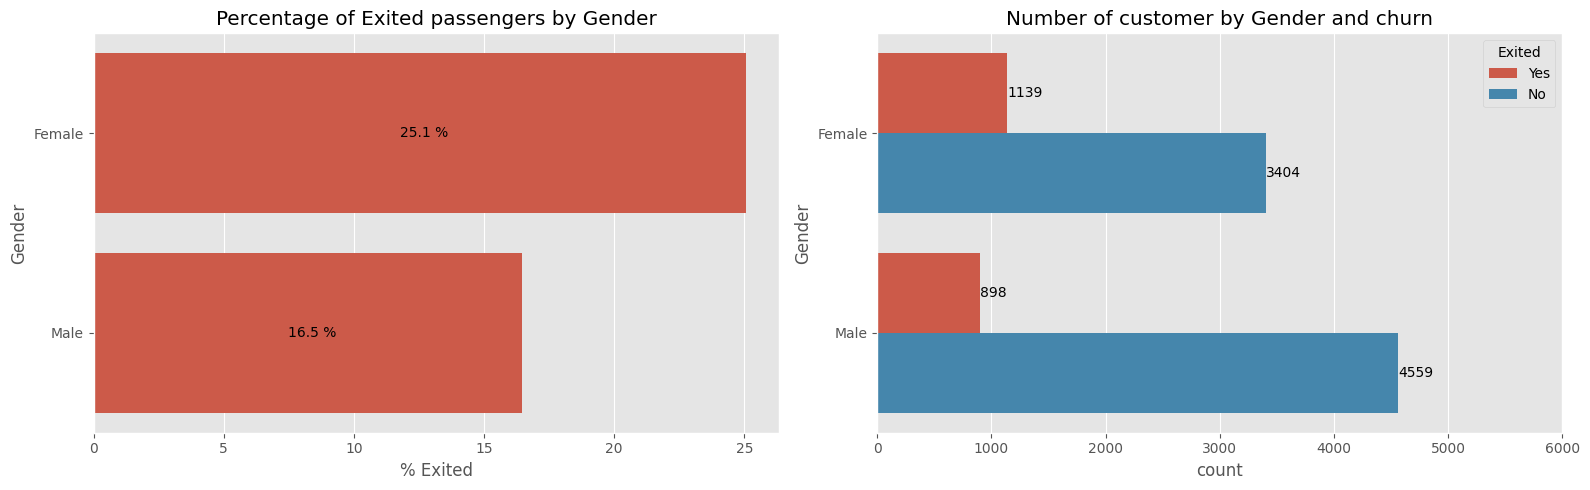

In [17]:
create_plot(data, 'Gender', x_maks=6000)

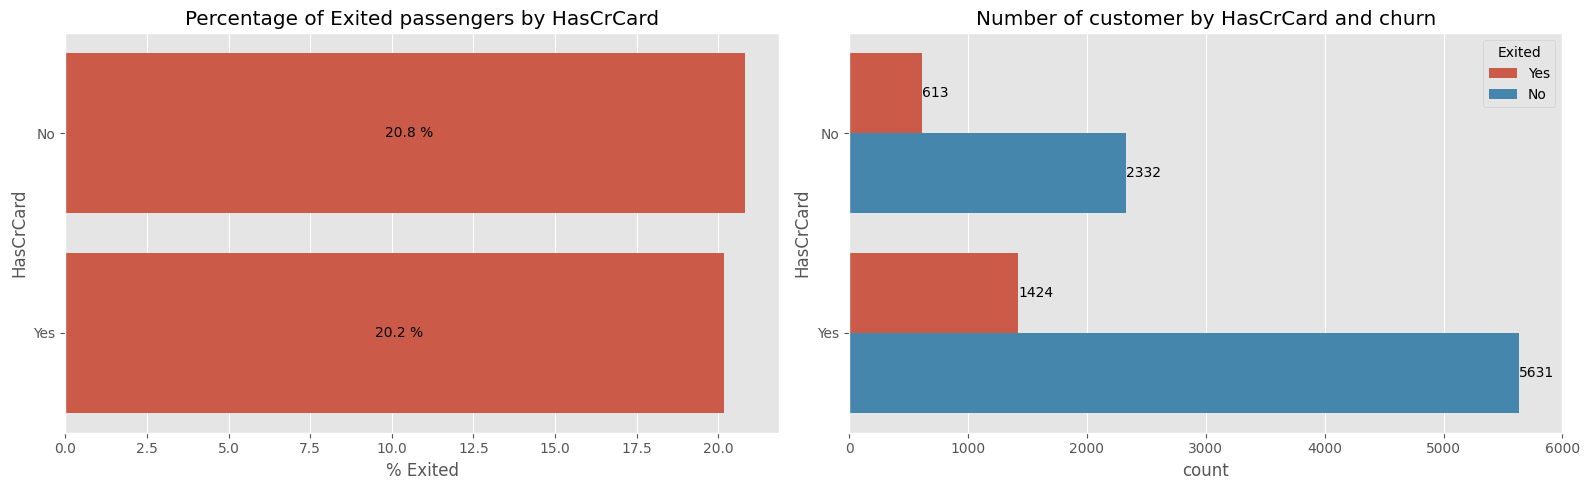

In [18]:
create_plot(data, 'HasCrCard', x_maks=6000)

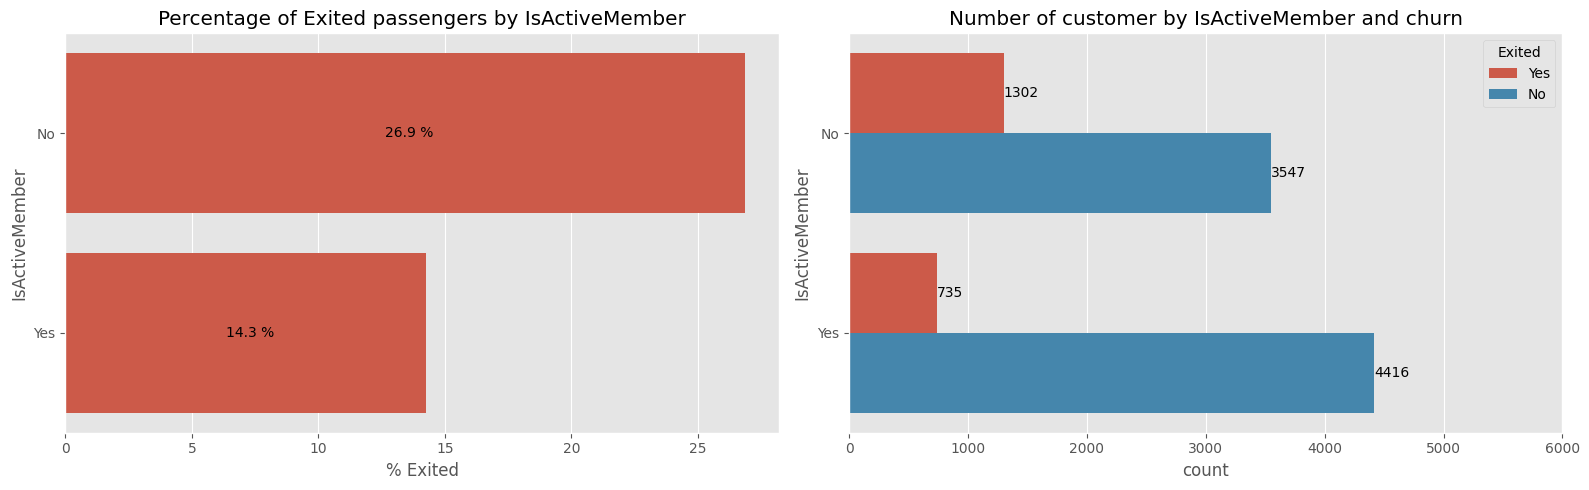

In [19]:
create_plot(data, 'IsActiveMember', x_maks=6000)

### **Data Preprocessing**

#### `Remove Unused Columns`

In [20]:
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

#### `Duplicates`

In [21]:
print(f"Total duplicates: {data[data.duplicated()].shape}")
print(f'Percentage of duplicates {len(data[data.duplicated()])/len(data)*100:.2f}%')

Total duplicates: (0, 11)
Percentage of duplicates 0.00%


There is no duplicates

#### `Missing Values`

In [22]:
pd.DataFrame({'Missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,Missing values
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


There is no missing values

#### `Imbalance Data`

In [23]:
# Check the class distribution 
from collections import Counter

print("Class distribution:", Counter(data['Exited']))

Class distribution: Counter({'No': 7963, 'Yes': 2037})


In [24]:
data['Exited'].value_counts(normalize=True)

Exited
No     0.7963
Yes    0.2037
Name: proportion, dtype: float64

The target data distribution can be seen as mildly or moderately imbalance

#### `Outliers`

In [25]:
def calculate_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in data.columns if data[var].dtypes != 'object']

for column in numerical:
    outlier_result, lower_bound, upper_bound = calculate_outliers(data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,CreditScore,15,0.15,383.00000,919.00000
1,Age,359,3.59,14.00000,62.00000
2,Tenure,0,0.00,-3.00000,13.00000
3,Balance,0,0.00,-191466.36000,319110.60000
4,NumOfProducts,60,0.60,-0.50000,3.50000
5,EstimatedSalary,0,0.00,-96577.09625,296967.45375


There are outliers in the numerical column with percentages ranging from 0.15% to 3.59%. We will examine the proportion of targets in these outliers.

In [26]:
# Proportion of outlier in target per column
proportion = []
indeces = []

for i, row in outlier_df.iterrows():
    outlier = data[(data[row['Column']] < row['Lower Bound']) | (data[row['Column']] > row['Upper Bound'])]
    percentages = (outlier['Exited'].value_counts(normalize=True)*100).values
    proportion.append(percentages)
    indeces.append(row['Column'])

pd.DataFrame(proportion, columns=['Not Churn', 'Churn'], index=indeces)

,Not Churn,Churn
CreditScore,100.000000,NaN
Age,79.665738,20.334262
Tenure,NaN,NaN
Balance,NaN,NaN
NumOfProducts,100.000000,NaN
EstimatedSalary,NaN,NaN


We find that the outlier in the `NumOfProducts` column has a different proportion of 0s and 1s in the `Exited` column compared to the rest of the data. Therefore, we will not remove this outlier because it contains information that impacts the target.

The outlier in the `Age` column has the same proportion of 0s and 1s in the `Exited` column compared to the initial condition. Therefore, we will attempt to handle the outlier in the age column with winsorizing.

#### `Collinearity`

In [27]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

We will carry out repeated testing until we obtain a VIF value < 10.

In [28]:
vif_df = calculate_vif(data[numerical])
dropped_columns = []

for i in range(len(vif_df)):
    if vif_df.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_df.iloc[0, 0])
        vif_df = calculate_vif(data[numerical].drop(columns=dropped_columns))

In [29]:
vif_df

,Feature,VIF
0,Age,8.272154
3,NumOfProducts,5.995174
4,EstimatedSalary,3.681241
1,Tenure,3.632270
2,Balance,2.407259


In [30]:
dropped_columns

['CreditScore']

There is multicollinearity in the CreditScore column, but we will try to maintain it first.

#### `Cardinality`

In [31]:
categorical = [var for var in data.drop(columns='Exited').columns if data[var].dtypes == 'object']

In [32]:
# creating a function to check cardinality
def check_cardinality(data):
    for feature in categorical:
        cardinality = len(data[feature].unique())
        print(f"Cardinality of {feature}: {cardinality}")

        if cardinality > 10:
            print(f"Warning: High cardinality in {feature}.")

check_cardinality(data)

Cardinality of Geography: 3
Cardinality of Gender: 2
Cardinality of HasCrCard: 2
Cardinality of IsActiveMember: 2


#### `Change Data Into Original Value`

In [33]:
data['HasCrCard'] = np.where(data['HasCrCard']=="Yes", 1, 0)
data['IsActiveMember'] = np.where(data['IsActiveMember']=="Yes", 1, 0)
data['Exited'] = np.where(data['Exited']=="Yes", 1, 0)

#### `Feature Engineering`

**Handling Outliers**

To handle outliers in the age column, we will try using winsorizing.

**Encoding**

Now let's encode our categorical features.
Here's what we'll do:

1. Transform the `Geography` and `Gender` features/columns using One Hot Encoding, as these features are not ordered/ordinal, and the number of unique data points is small.

**Scaling**

We will use the Robust Scaler because our data contains outliers, and the Robust Scaler will not be affected by outliers. We can re-adjust the scaler later to find the best scaler.

**Imbalance Data**

We can see that the dataset is mildly imbalanced because the minority class proportion is 20.4%.

To address this, we can test whether the modeling requires a resampling method to ensure a more balanced class distribution.

The resampling method we will use is SMOTE. However, we can re-arrange the resampler later to find the best one.

### **Modeling**

#### `Define Features (X) and Target (y)`

In [34]:
# Features
X = data.drop(columns='Exited')

# target
y = data['Exited']

#### `Data Splitting`

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

#### `Pipeline`

| Technique | Action |
| ----------------------------- | ----------- |
| Handling Outliers | Using winsorize with a 1% limit for the `Age` column |
| One Hot Encoding | Transforming the `Gender` and `Geography` columns with <= 10 unique values ​​|
| Robust Scaling | Scaling transformation of each feature using a robust scaler |
| SMOTE | Resampling the training data due to imbalanced targets |

In [36]:
def winsorize_with_pandas(s, limits):
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

In [37]:
# Outlier Handling
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from scipy.stats.mstats import winsorize
from typing import Literal

class HandlingOutliers(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        return self 
    
    def transform(self, X, y=None):
        data = X.copy()
        data['Age'] = pd.Series(winsorize_with_pandas(data['Age'], limits=(0.01, 0.01)))
        return data
    
    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

In [38]:
# Column Transformer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['Gender', 'Geography']),
], remainder='passthrough')

In [39]:
# Scaling
scaler = RobustScaler()

In [40]:
# Resampling
smote = SMOTE(random_state=0)
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)

resamplers = [rus, ros, smote]

In [41]:
Pipeline([
    ('outlier', HandlingOutliers()), # Winsorizing
    ('transformer', transformer), # OHE
    ('scaler', scaler), # Robustscaler
    ('resampler', smote), # smote
])

Pipeline(steps=[('outlier', HandlingOutliers()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['Gender', 'Geography'])])),
                ('scaler', RobustScaler()),
                ('resampler', SMOTE(random_state=0))])

#### `Model Selection`

In [42]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

In [43]:
# Define the models

# Decision Tree
tree = DecisionTreeClassifier(random_state=0)

# RandomForest
rf = RandomForestClassifier(random_state=0)

# Adaboost
adaboost = AdaBoostClassifier(random_state=0)

# Gradientboost
gradboost = GradientBoostingClassifier(random_state=0)

# ExtremeGradientBoost
xgboost = XGBClassifier(random_state=0, verbosity=0)

In [44]:
from sklearn.metrics import fbeta_score, make_scorer

# Create scorer
f2_score = make_scorer(fbeta_score, beta=2)

In [45]:
# Model selection
models = [tree, rf, adaboost, gradboost, xgboost]

f2_mean = []
f2_std = []
all_f2 = []
model_name = []

# Find the best model 
for algoritma in models:

    model_pipe = Pipeline([
        ('outlier', HandlingOutliers()),
        ('transformer', transformer),
        ('scaler', scaler),
        ('resampler', smote),
        ('model', algoritma)
    ])

    skfold = StratifiedKFold(n_splits = 5)

    model_cv = cross_val_score(
        model_pipe,                 # models inside pipeline
        X_train,                    # data before preprocessing
        y_train, 
        cv = skfold, 
        scoring = f2_score,
        error_score='raise'
        )

    f2_mean.append(model_cv.mean())
    f2_std.append(model_cv.std())
    all_f2.append(model_cv.round(4))
    model_name.append(algoritma.__class__.__name__)

In [46]:
# f2 scores for each algorithm
pd.DataFrame({
    'model': model_name,
    'mean': f2_mean,
    'std': f2_std,
    'all_score' : all_f2
}).sort_values('mean', ascending=False)

,model,mean,std,all_score
2,AdaBoostClassifier,0.654019,0.016524,"[0.6762, 0.6572, 0.6655, 0.6405, 0.6306]"
3,GradientBoostingClassifier,0.636935,0.017321,"[0.6526, 0.6185, 0.6625, 0.6273, 0.6239]"
1,RandomForestClassifier,0.589384,0.019803,"[0.5943, 0.5961, 0.6114, 0.593, 0.5521]"
4,XGBClassifier,0.581117,0.013320,"[0.5577, 0.5973, 0.584, 0.578, 0.5886]"
0,DecisionTreeClassifier,0.541901,0.011258,"[0.5448, 0.547, 0.5582, 0.5344, 0.5252]"


- Based on the five models tested, the AdaBoost model produced the highest f2-score.
- Let's examine the performance of the five models on the test set.

*Predict Benchmark Model to Test Set*

In [47]:
list_f2 = []
list_resample = []

# Find the best models 
for algoritma in models :

    model_pipe = Pipeline([
        ('outlier', HandlingOutliers()),
        ('transformer', transformer),
        ('scaler', scaler),
        ('resampler', smote),
        ('model', algoritma)
    ])

    # fitting
    model_pipe.fit(X_train, y_train)

    # predict
    y_pred = model_pipe.predict(X_test)

    # evaluate
    score = fbeta_score(y_test, y_pred, beta=2)
    list_f2.append(score)

In [48]:
# f2 scores for each algorithm
pd.DataFrame({
    'model': model_name,
    'f2 (test_set)': list_f2
}).sort_values('f2 (test_set)', ascending=False)

,model,f2 (test_set)
2,AdaBoostClassifier,0.630979
3,GradientBoostingClassifier,0.599315
1,RandomForestClassifier,0.571855
4,XGBClassifier,0.549030
0,DecisionTreeClassifier,0.537660


- From the experiment above, the AdaBoost model produced the highest recall on the training data set.
- Next, we will try tuning the AdaBoost, Gradient Boost, and XGBoost models.

#### `Hyperparameter Tuning`

**AdaBoost**

In [49]:
# learning rate
learning_rate = list(np.arange(0.01,1, 0.01))

# number of trees
n_estimators = list(np.arange(50,500))

# algorithm to find the best AdaBoost
algorithm = ['SAMME', 'SAMME.R']

# Hyperparameter space Adaboost
hyperparam_space_adaboost = {
    'resampler':[smote, rus, ros, None],
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__algorithm':algorithm,

}

In [50]:
# Benchmark model 1
adaboost = AdaBoostClassifier(random_state=0)

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Create the algorithm chains
estimator_adaboost = Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler', smote),
    ('model', adaboost)
    ])

# Hyperparameter tuning
tuned_adaboost = RandomizedSearchCV(
    estimator=estimator_adaboost, 
    param_distributions = hyperparam_space_adaboost, 
    cv = skf, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=30
)

In [51]:
# fitting 
tuned_adaboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('outlier', HandlingOutliers()),
                                             ('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Geography'])])),
                                             ('scaler', RobustScaler()),
                                             ('resampler',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              AdaBoostClassifi...
                                                                 0.25, 0.26,
                                                                 0.27, 0.28,
                                                                 0.29000000000000004,
                                                                 0.3, ...],
                                        'model__n_estimators': [50, 51, 52, 53,
                                                                54, 55, 56, 57,
                                                                58, 59, 60, 61,
                                                                62, 63, 64, 65,
                                                                66, 67, 68, 69,
                                                                70, 71, 72, 73,
                                                                74, 75, 76, 77,
                                                                78, 79, ...],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      None]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [52]:
# Best score from grid_search
print(f'F2 Score on train set: {tuned_adaboost.best_score_:.3f}')

# Hyperparameters for the best score from tuned_adaboost
print(f'Best parameter: {tuned_adaboost.best_params_}')

F2 Score on train set: 0.668
Best parameter: {'resampler': RandomOverSampler(random_state=0), 'model__n_estimators': 296, 'model__learning_rate': 0.45, 'model__algorithm': 'SAMME'}


**GradientBoostingClassifier**

In [53]:
# Tree Depth
max_depth = list(np.arange(1,10))

# Learning Rate
learning_rate = list(np.arange(0.01,1, 0.01))

# Number of Trees
n_estimators = list(np.arange(50,500))

# Number of Trainset Rows per Tree (% of Total Trainset Rows)
subsample = list(np.arange(0.2,1,0.1))

# Number of Features Used for Splitting Considerations (% of Total Trainset Columns)
max_features = list(np.arange(1,10))

# Gradient Boosting Hyperparameter Space
hyperparam_space_gradboost = {
    'resampler':[smote, rus, ros, None],
    'model__max_depth':max_depth ,
    'model__learning_rate':learning_rate, 
    'model__n_estimators':n_estimators, 
    'model__subsample':subsample, 
    'model__max_features':max_features
}

In [54]:
# Benchmark model 2
gradboost = GradientBoostingClassifier(random_state=0)

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Create the algorithm chains
estimator_gradboost = Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler', smote), 
    ('model', gradboost)
    ])

# Hyperparameter tuning
tuned_gradboost = RandomizedSearchCV(
    estimator=estimator_gradboost, 
    param_distributions = hyperparam_space_gradboost, 
    cv = skf, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=30
)

In [55]:
# fitting 
tuned_gradboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('outlier', HandlingOutliers()),
                                             ('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Geography'])])),
                                             ('scaler', RobustScaler()),
                                             ('resampler',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              GradientBoosting...
                                        'model__subsample': [0.2,
                                                             0.30000000000000004,
                                                             0.4000000000000001,
                                                             0.5000000000000001,
                                                             0.6000000000000001,
                                                             0.7000000000000002,
                                                             0.8000000000000003,
                                                             0.9000000000000001],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      None]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [56]:
# Best score from randomized_search
print(f'F2 Score on train set: {tuned_gradboost.best_score_:.3f}')

# Hyperparameters for the best score from tuned_gradboost
print(f'Best parameter: {tuned_gradboost.best_params_}')

F2 Score on train set: 0.666
Best parameter: {'resampler': RandomOverSampler(random_state=0), 'model__subsample': 0.8000000000000003, 'model__n_estimators': 401, 'model__max_features': 7, 'model__max_depth': 1, 'model__learning_rate': 0.32}


**XGBoost**

In [57]:
# tree depth
max_depth = list(np.arange(1,11))

# learning rate
learning_rate = list(np.arange(0.01, 1.0, 0.01))

# number of trees
n_estimators = list(np.arange(100,201))

# number of rows used to grow each tree (% of total train set rows)
subsample = list(np.arange(0.2, 1.0, 0.1))

# gamma (min_impurity_decrease)
gamma = list(np.arange(1,11))

# number of features used for each tree (% of total train set columns)
colsample_bytree = list(np.arange(0.1, 1.0, 0.2))

# alpha (regularization)
reg_alpha = list(np.logspace(-3,3,7))

# Hyperparam space XGboost
hyperparam_space_xgboost = {
    'resampler':[smote, rus, ros, None],
    'model__max_depth':max_depth, 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [58]:
# Benchmark model 3
xgboost = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgboost = Pipeline([
        ('outlier', HandlingOutliers()),
        ('tansformer', transformer),
        ('scaler', scaler),
        ('resampler', smote), 
        ('model', xgboost)
        ])

# Hyperparameter tuning
tuned_xgboost = RandomizedSearchCV(
    estimator_xgboost, 
    param_distributions = hyperparam_space_xgboost, 
    cv = skf, 
    scoring = f2_score, 
    n_jobs = -1,  
    random_state=0,
    n_iter=30 
)

In [59]:
# fitting 
tuned_xgboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('outlier', HandlingOutliers()),
                                             ('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Geography'])])),
                                             ('scaler', RobustScaler()),
                                             ('resampler',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              XGBClassifier(bas...
                                        'model__subsample': [0.2,
                                                             0.30000000000000004,
                                                             0.4000000000000001,
                                                             0.5000000000000001,
                                                             0.6000000000000001,
                                                             0.7000000000000002,
                                                             0.8000000000000003,
                                                             0.9000000000000001],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      None]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [60]:
# Best score from randomized_search
print(f'F2 Score on train set: {tuned_xgboost.best_score_:.3f}')

# Hyperparameters for the best score from tuned_xgboost
print(f'Best parameter: {tuned_xgboost.best_params_}')

F2 Score on train set: 0.683
Best parameter: {'resampler': RandomUnderSampler(random_state=0), 'model__subsample': 0.5000000000000001, 'model__reg_alpha': 10.0, 'model__n_estimators': 157, 'model__max_depth': 6, 'model__learning_rate': 0.62, 'model__gamma': 4, 'model__colsample_bytree': 0.30000000000000004}


*Predict Tuned Model to Test Set*

**AdaBoost**

In [61]:
# Model after hyperparameter tuning
tuned_model = tuned_adaboost.best_estimator_

# Fitting model
tuned_model.fit(X_train, y_train)

# Predict to test set
y_pred = tuned_model.predict(X_test)

# Evaluate f2 score on test set
fbeta_score(y_test, y_pred, beta=2)

0.6390977443609023

**GradientBoostingClassifier**

In [62]:
# Model after hyperparameter tuning
tuned_model = tuned_gradboost.best_estimator_

# Fitting model
tuned_model.fit(X_train, y_train)

# Predict to test set
y_pred = tuned_model.predict(X_test)

# Evaluate f2 score on test set
fbeta_score(y_test, y_pred, beta=2)

0.6571936056838366

**XGBoost**

In [63]:
# Model after hyperparameter tuning
tuned_model = tuned_xgboost.best_estimator_

# Fitting model
tuned_model.fit(X_train, y_train)

# Predict to test set
y_pred = tuned_model.predict(X_test)

# Evaluate f2 score on test set
fbeta_score(y_test, y_pred, beta=2)

0.6497797356828194

| Model                   | Train Set | Test Set |
| ----------------------- | --------- | -------- |
| AdaBoost Before Tuning  | 0.654     | 0.631    |
| AdaBoost After Tuning   | 0.668     | 0.639    |
| GradBoost Before Tuning | 0.637     | 0.599    |
| GradBoost After Tuning  | 0.666     | 0.657    |
| XGBoost Before Tuning   | 0.581     | 0.549    |
| XGBoost After Tuning    | 0.683     | 0.650    |


**Insight**

- The model selected for modeling this dataset is **GradBoost**.
- Hyperparameter tuning **improved** the performance of the XGBoost model based on the f2 score.
- The best hyperparameters based on RandomizedSearch are **'resampler': RandomOverSampler(random_state=0), 'model__subsample': 0.8000000000000003, 'model__n_estimators': 401, 'model__max_features': 7, 'model__max_depth': 1, 'model__learning_rate': 0.32**

In [99]:
final_model = tuned_gradboost.best_estimator_

#### `Model Evaluation`

**Best Algorithm: Gradient Booster**

How the algorithm works?
- Gradient Boosting builds a strong model by combining many weak models (usually decision trees) sequentially.

Logic behind Gradient booster
* Start with a simple model that makes initial predictions.
* Calculate the errors (residuals) between predictions and true values.
* Train the next tree to predict those errors — i.e., to fix what the previous model missed.
* Repeat this process many times, each new tree correcting the mistakes of the ensemble.
* Combine all trees’ outputs into one final prediction (a weighted sum).

Why it performs best?

* Each iteration focuses on the hardest samples to predict, improving accuracy efficiently.
* It naturally handles complex, nonlinear patterns.
* After tuning, the model balances bias and variance, giving strong generalization (high train and test F₂-scores).

So, Gradient Boosting works by iteratively learning from its own mistakes, making it powerful and accurate for structured data problems 

**Model limitation**

We must be careful when interpreting data outside the independent observation interval of the variables.

This model is only valid for the data range used in this modeling, namely:

* `CreditScore` between 350 and 850
* `Age` between 18 and 92 years
* `Tenure` between 0 and 10 years
* `Balance` between 0 and 250898
* `NumOfProducts` between 1 and 4
* `HasCrCard` with a value of 1 or 0
* `IsActiveMember` with a value of 1 or 0
* `EstimatedSalary` between 11.58 and 199992.48

**Learning Curve**

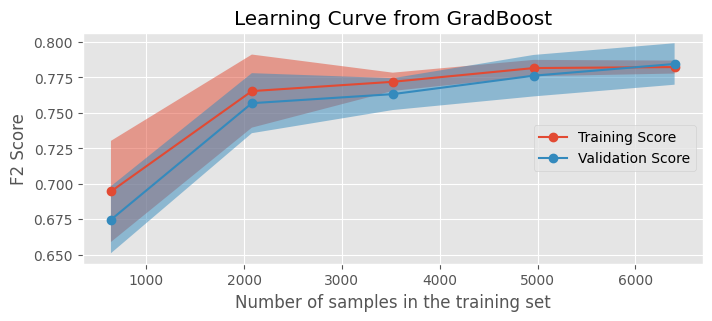

In [134]:
from sklearn.model_selection import LearningCurveDisplay

# Set figure size
fig, ax = plt.subplots(figsize=(8, 3))

# Set the required parameters
common_params={
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {'marker': 'o'},
    "score_name": f2_score
}

# Generate learning curve plot
LearningCurveDisplay.from_estimator(final_model, **common_params, ax=ax)

# Set title and legend
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ['Training Score', 'Validation Score'], loc='center right')
ax.set_title(f'Learning Curve from GradBoost')
ax.set_ylabel('F2 Score')

# Show the plot
plt.show()

**Feature Importances - Global explanation** 

In [101]:
onehot_features = list(final_model[1].transformers_[0][1].get_feature_names_out())
remainder_features = list(X.columns[final_model[1].transformers_[1][2]])

feature_names = onehot_features + remainder_features

In [102]:
df_coef = pd.DataFrame({
    "feature" : feature_names, 
    "importances" : final_model['model'].feature_importances_
}).sort_values(by='importances', ascending=False)

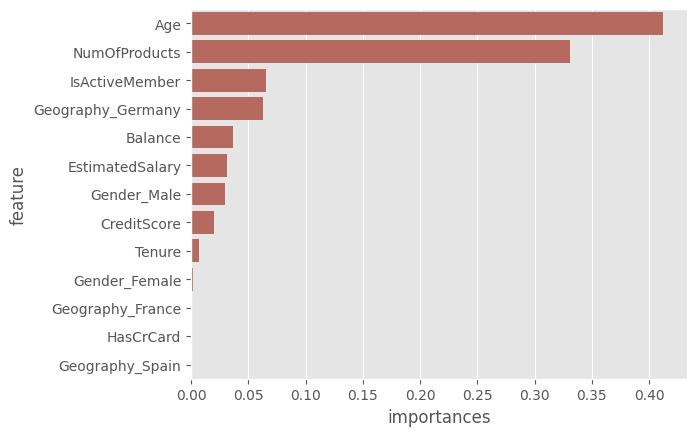

In [103]:
sns.barplot(data=df_coef, x='importances', y='feature', saturation=0.5)
plt.show()

**Shapley Value of Explanations (SHAP)**

In [104]:
# Model
final_model[-1]

GradientBoostingClassifier(learning_rate=0.32, max_depth=1, max_features=7,
                           n_estimators=401, random_state=0,
                           subsample=0.8000000000000003)

In [105]:
# create preprocessed features
X_train_processed = final_model[0:-2].fit_transform(X_train)
X_train_resampled, y_train_resampled = final_model[-2].fit_resample(X_train_processed, y_train)

 99%|===================| 12659/12740 [00:57<00:00]        

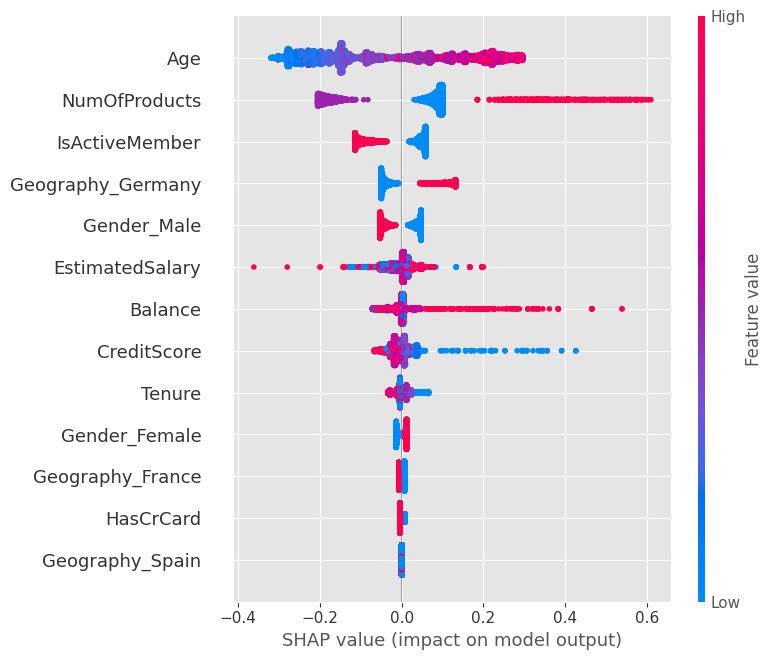

In [106]:
import shap

shap_values = shap.TreeExplainer(final_model[-1],
                                 data = X_train_resampled,
                                 feature_perturbation = "interventional",
                                 model_output="probability").shap_values(X_train_resampled)
                                 
shap.summary_plot(shap_values, X_train_resampled,feature_names = feature_names) # Global explanation

**Shapley Value of Explanations (SHAP) Per Observation Feature**

In [107]:
# Start js (must have)
shap.initjs()

In [108]:
def shap_plot(j,model,S):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [109]:
# create a preprocessed X_test dataframe
X_test_processed = final_model[0:-2].fit_transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

In [110]:
# Lets compare with the real result # Local explanation # SHAP
print(f"The prediction must predict this passenger is: {('Buy' if y_test.iloc[0] == 1 else 'Not Buy')} from y_test")

shap_plot(0,final_model[-1],X_test_processed_df)

The prediction must predict this passenger is: Buy from y_test


**Local Interpretable Model-agnostic Explanation (LIME)** 

In [111]:
import lime
from lime import lime_tabular

In [112]:
# Explainer based
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_resampled),
    feature_names=feature_names,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

**Explain Feature based on Pyplot**

The prediction must predict this customer is: Churn from y_test


''

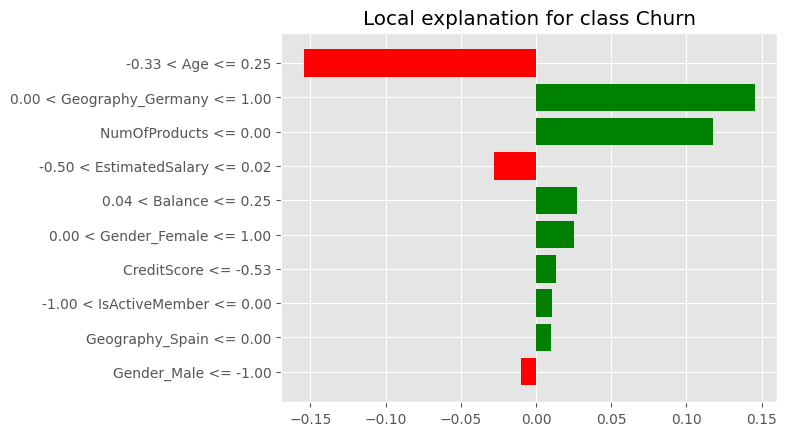

In [113]:
# Try to the observation 0
# Lets compare with the real result
print(f"The prediction must predict this customer is: {('Churn' if y_test.iloc[0] == 1 else 'Not churn')} from y_test")

exp = explainer.explain_instance(X_test_processed_df.iloc[0], 
                                 final_model[-1].predict_proba, 
                                 num_features=10)
exp.as_pyplot_figure()
;

**Classification Report**

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1593
           1       0.46      0.72      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.77      0.79      2000



**PR-Curve**

Best Threshold=0.7804971904237813


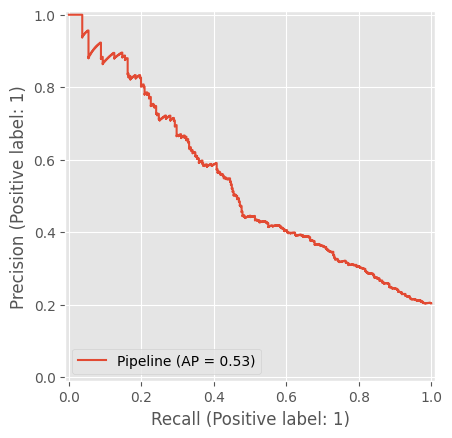

In [115]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_test, final_model.predict_proba(X_test)[:,1])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}')

PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test)
plt.show()

**Predict Probability vs Actual**

In [116]:
y_proba = final_model.predict_proba(X_test)[:,1]

In [117]:
df_proba = pd.DataFrame(y_test)
df_proba['probability'] = y_proba

In [118]:
def probability_range(x):
    if x < 0.1:
        probability_range = '0.0 - 0.1'
    elif 0.1 <= x < 0.2:
        probability_range = '0.1 - 0.2'
    elif 0.2 <= x < 0.3:
        probability_range = '0.2 - 0.3'
    elif 0.3 <= x < 0.4:
        probability_range = '0.3 - 0.4'
    elif 0.4 <= x < 0.5:
        probability_range = '0.4 - 0.5'
    elif 0.5 <= x < 0.6:
        probability_range = '0.5 - 0.6'
    elif 0.6 <= x < 0.7:
        probability_range = '0.6 - 0.7'
    elif 0.7 <= x < 0.8:
        probability_range = '0.7 - 0.8'
    elif 0.8 <= x < 0.9:
        probability_range = '0.8 - 0.9'
    else:
        probability_range = '0.9 - 1.0'
        
    return probability_range

df_proba.insert(1, 'probability range',value ='')

df_proba['probability range'] = df_proba['probability'].apply(probability_range)

In [119]:
df_probability = df_proba.groupby(['probability range', 'Exited']).size().unstack().reset_index()
df_probability['total'] = df_probability[1]+df_probability[0]
df_probability['actual probability'] = (df_probability[1]/df_probability['total']).round(2)
df_probability['predicted probability'] = df_proba.groupby(['probability range'])['probability'].mean().values.round(2)
df_probability = df_probability.sort_values(by='probability range', ascending=False)
df_probability = df_probability.rename(columns = {0:'no', 1:'yes'})
df_probability

Exited,probability range,no,yes,total,actual probability,predicted probability
9,0.9 - 1.0,22,85,107,0.79,0.94
8,0.8 - 0.9,100,81,181,0.45,0.85
7,0.7 - 0.8,138,41,179,0.23,0.75
6,0.6 - 0.7,152,56,208,0.27,0.65
5,0.5 - 0.6,164,34,198,0.17,0.55
4,0.4 - 0.5,212,36,248,0.15,0.45
3,0.3 - 0.4,265,27,292,0.09,0.35
2,0.2 - 0.3,301,23,324,0.07,0.25
1,0.1 - 0.2,206,17,223,0.08,0.15
0,0.0 - 0.1,33,7,40,0.18,0.07


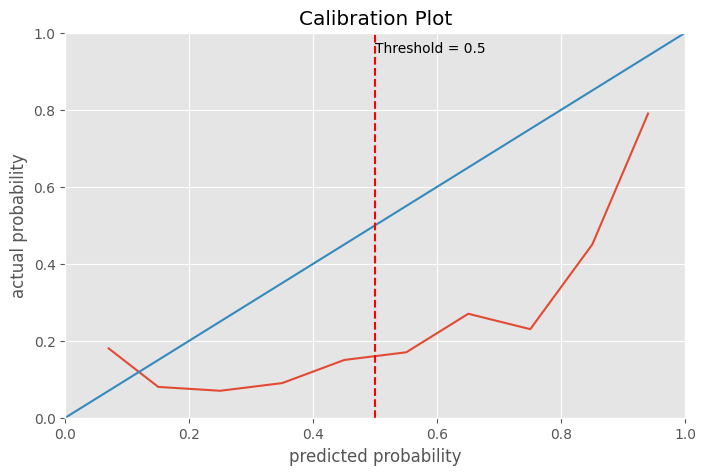

In [120]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_probability.sort_values(by='probability range', ascending=True), x='predicted probability', y='actual probability')
value = [x/100 for x in range(0,110,10)]
sns.lineplot(x=value, y=value)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axvline(0.5, color='r', linestyle='--')
plt.annotate('Threshold = 0.5', (0.5,0.95))
plt.title('Calibration Plot')
plt.show()

**Confusion Matrix**

<Axes: >

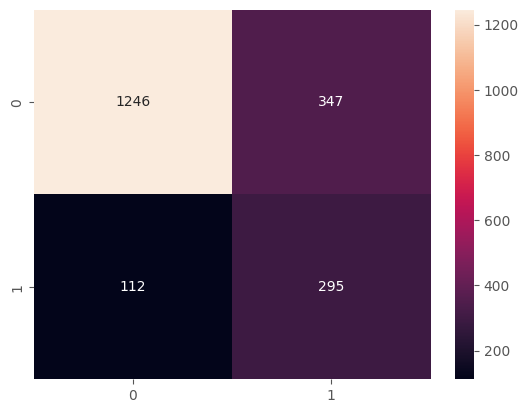

In [121]:
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

**Confusion matrix**

Based on the confusion matrix for the test set above, we can see that with the model we created, we found:
- Number of potential customers who actually churned and were predicted to churn (True Positive): 295 people
- Number of potential customers who actually churned but were predicted not to churn (False Negative): 112 people
- Number of potential customers who actually did not churn and were predicted not to churn (True Negative): 1246 people
- Number of potential customers who actually did not churn but were predicted to churn (False Positive): 347 people
---

**Business impact**

**Without Machine Learning**

Based on the assumptions presented in the Business Understanding section, we assume the cost impact is as follows:
- Retention cost per customer --> $0.67 per month per customer
- Cost of losing customers (Churn) --> $10.33 per month per customer (total lost revenue and Customer Acquisition Cost)

Without using machine learning, we cannot predict whether a customer will churn or not. The impact is that we tend to offer retention programs to all customers.

Number of potential customers for the calculation:
- potential customers for whom we offer retention programs = TP + FP + TN + FN = 2,000 people
- potential customers who actually churn = TP + FN = 407 people

Cost Estimation
- 2,000 people x $0.67 per month per customer + 407 people x $10.33 per month per customer = ($1,340 + $4,204.31)/month = $5,544.31 per month

Therefore, the loss is approximately **$5,544.31 per month** if we don't use machine learning.

---

**With Machine Learning**

When we use machine learning, we only offer retention programs to potential customers predicted to churn.

Number of potential customers for the calculation basis:
- potential customers for whom we provided a retention program = TP + FP = 295 + 347 = 642 people
- potential customers who actually churned = 407 people

Cost Estimation
- 642 people x $0.67 per month per customer + 407 people x $10.33 per month per customer = ($430.14 + $4204.31)/month = $4634.45 per month

Therefore, the loss is approximately **$4634.45  per month**

---
Potential Loss Reduction = $5544.31 - $4634.45  = $909.86 per month

**% Reduction** = 909.86 / 5544.31 x 100 = **16.4%**

Based on the test set, our model can reduce losses due to churn by **16.4%** in a month.

#### `Saving Model`

We will save the model both in pickle and joblib

`pickle`

In [135]:
import pickle

# Define final model
final_model = tuned_gradboost.best_estimator_

# Fitting model to all data
final_model.fit(X, y)

# Save Model
pickle.dump(final_model, open('gradboost_for_churn.sav', 'wb'))

In [136]:
# Load Model
model_loaded_pickle = pickle.load(open('gradboost_for_churn.sav', 'rb'))

**Predict to Existing Data**

In [137]:
# predict to user 1344
X_test.iloc[[0]]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1344,460,Germany,Female,40,6,119507.58,2,1,0,91560.63


In [138]:
# The actual class of user 1344 is churn
y_test.iloc[0]

1

In [139]:
# prediction result for user 1134 is also churn
model_loaded_pickle.predict(X_test.iloc[[0]])

array([0])

**Predict to New Data**

In [140]:
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [141]:
new_data = pd.DataFrame({
    'CreditScore' : [750, 100, 500], 
    'Geography' : ['France', 'Spain', 'Germany'], 
    'Gender' : ['Male', 'Female', 'Male'], 
    'Age' : [37, 20, 60], 
    'Tenure' : [5, 1, 10], 
    'Balance' : [100000, 5000, 200000],
    'NumOfProducts' : [2, 1, 3], 
    'HasCrCard' : [1, 0, 0], 
    'IsActiveMember' : [1, 0, 1], 
    'EstimatedSalary' : [100000, 50000, 150000]
})

new_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,750,France,Male,37,5,100000,2,1,1,100000
1,100,Spain,Female,20,1,5000,1,0,0,50000
2,500,Germany,Male,60,10,200000,3,0,1,150000


In [142]:
# prediction result for new data
model_loaded_pickle.predict(new_data)

array([0, 1, 1])

`joblib`

In [143]:
# !pip install joblib

In [144]:
import joblib

# Define final model
final_model = tuned_gradboost.best_estimator_

# Fitting model to all data
final_model.fit(X, y)

# Save Model
joblib.dump(final_model, 'gradboost_joblib')

['gradboost_joblib']

In [145]:
# Load Model
model_loaded_joblib = joblib.load('gradboost_joblib')

In [146]:
# Prediction result for new data
model_loaded_joblib.predict(new_data)

array([0, 1, 1])